In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import argparse
from scipy.sparse.linalg import cg

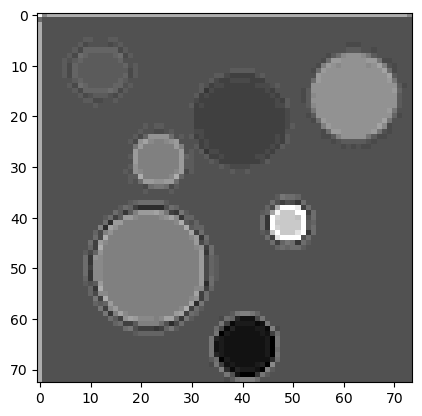

In [9]:
img1 = cv.imread('5.png', 0)
plt.imshow(img1, cmap='gray')
plt.show()

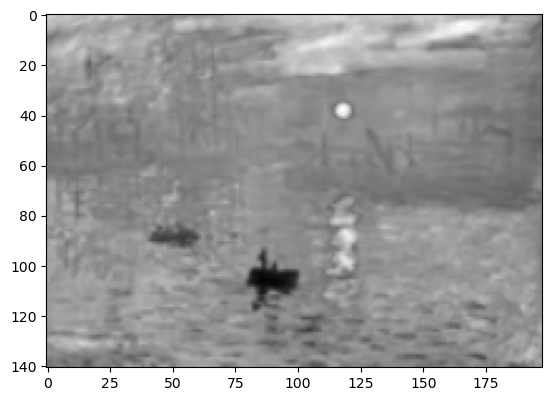

In [12]:
'''
最大值法
'''
img1 = cv.imread('6.png', 1)
img1_temp = img1.max(axis=2)
plt.imshow(img1_temp, cmap='gray')
plt.show()

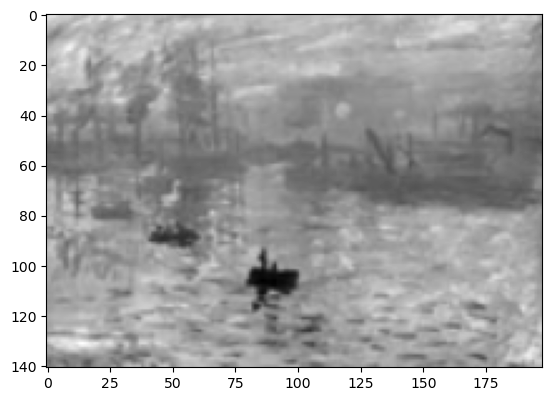

In [15]:
'''
平均值
'''
img1 = cv.imread('6.png', 1)
img1_temp = img1.mean(axis=2)
plt.imshow(img1_temp, cmap='gray')
plt.show()

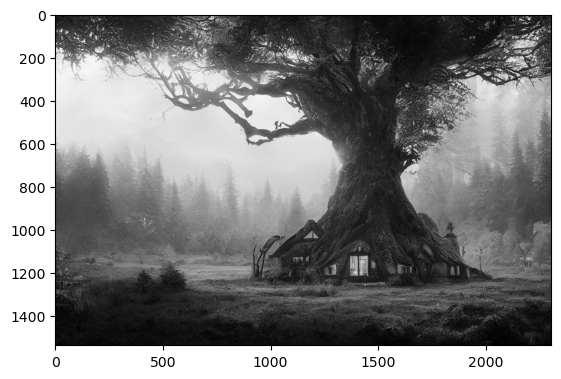

In [56]:
'''
加权平均法
'''
img1 = cv.imread('1.png', 1)
img1_temp = np.dot(img1,[0.333,0.333,0.333])
plt.imshow(img1_temp, cmap='gray')
plt.show()

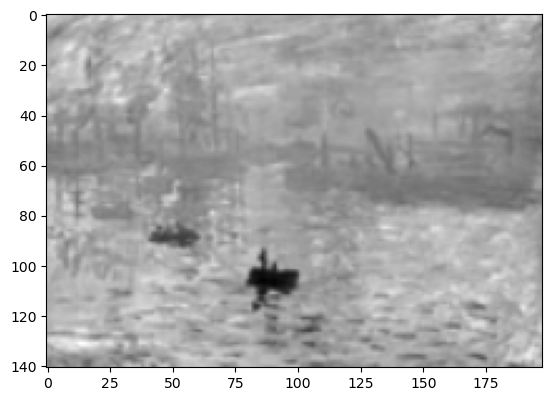

In [18]:
'''
加权平均法
'''
img1 = cv.imread('6.png', 1)
img1_temp = np.dot(img1,[0.7152,0.0722,0.2126])
plt.imshow(img1_temp, cmap='gray')
plt.show()

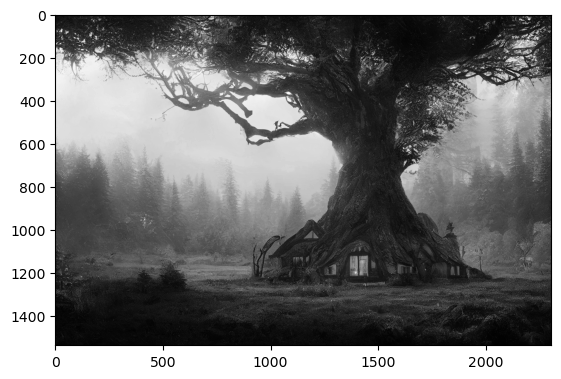

In [61]:
'''
加权平均法
'''
img1 = cv.imread('1.png', 1)
img1_temp = np.dot(img1,[0.587,0.114,0.299])
plt.imshow(img1_temp, cmap='gray')
plt.show()

start processing image 6.png


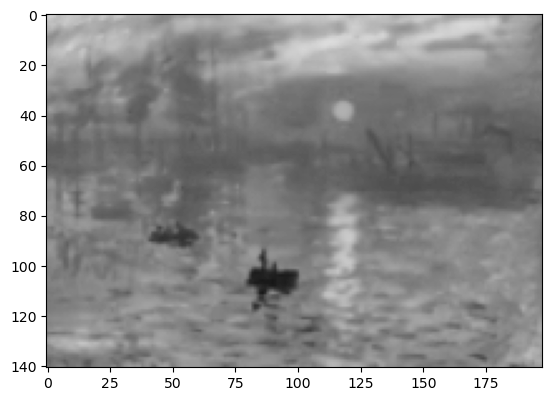

In [5]:
'''
Color2Gray: Salience-Preserving Color Removal
'''
input_img = '6.png'
npi = 1
dpi = 4
alpha = 20
theta = npi * math.pi / dpi
u = 8 
img = cv.imread(input_img)
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)
height, width, channals = img.shape
pixels = img_lab.astype(int)
cos_theta, sin_theta = math.cos(theta), math.sin(theta)
ps = pixels.reshape((height * width, 3))
l, a, b = map(list, zip(*ps))
l = list(map(lambda x: x * 100 / 255, l))
a = list(map(lambda x: x - 128, a))
b = list(map(lambda x: x - 128, b))
l_avg = sum(l) / len(l)
pixels = np.array(list(zip(l,a,b))).reshape((height,width,3))

def delta(i, j, alpha, theta):
    da, db = i[1] - j[1], i[2] - j[2]
    dl = i[0] - j[0]
    dist_c = math.sqrt(da ** 2 + db ** 2)
    crunch_dist_c = alpha * math.tanh(dist_c / alpha)
    if abs(dl) > crunch_dist_c:
        return dl
    if da * cos_theta + db * sin_theta >= 0:
        return crunch_dist_c
    return -crunch_dist_c

nneighb = [[0 for _ in range(0, width)] for _ in range(0, height)]
for i in range(0, height):
    for j in range(0, width):
        neighb_top = i - u if i - u >= 0 else 0
        neighb_bot = i + u if i + u <= height - 1 else height - 1
        neighb_left = j - u if j - u >= 0 else 0
        neighb_right = j + u if j + u <= width - 1 else width - 1
        for ni in range(neighb_left, neighb_right+1):
            for nj in range(neighb_top, neighb_bot+1):
                if i * width + j != ni * width + nj:
                    nneighb[i][j] += 1

#计算delta_ij
deltas = [[0 for _ in range(0, height * width)] for _ in range(0, height * width)]
for i in range(0, height):
    for j in range(0, width):
        neighb_top = i - u if i - u >= 0 else 0
        neighb_bot = i + u if i + u <= height - 1 else height - 1
        neighb_left = j - u if j - u >= 0 else 0
        neighb_right = j + u if j + u <= width - 1 else width - 1
        for ni in range(neighb_top, neighb_bot+1):
            for nj in range(neighb_left, neighb_right+1):
                deltas[i * width + j][ni * width + nj] = delta(pixels[i][j], pixels[ni][nj], alpha, theta)

#计算矩阵A
diag = []
for row in nneighb:
    for col in row:
        diag.append(2 * col)
        
A = np.diag(diag)
for i in range(0, height):
    for j in range(0, width):
        neighb_top = i - u if i - u >= 0 else 0
        neighb_bot = i + u if i + u <= height - 1 else height - 1
        neighb_left = j - u if j - u >= 0 else 0
        neighb_right = j + u if j + u <= width - 1 else width - 1
        for ni in range(neighb_top, neighb_bot+1):
            for nj in range(neighb_left, neighb_right+1):
                if i * width + j != ni * width + nj:
                    A[i * width + j][ni * width + nj] = -2
#计算矩阵B
B = np.zeros((height * width,))
for i in range(0, height):
    for j in range(0, width):
        neighb_top = i - u if i - u >= 0 else 0
        neighb_bot = i + u if i + u <= height - 1 else height - 1
        neighb_left = j - u if j - u >= 0 else 0
        neighb_right = j + u if j + u <= width - 1 else width - 1
        for ni in range(neighb_top, neighb_bot+1):
            for nj in range(neighb_left, neighb_right+1):
                B[i * width + j] += deltas[i * width + j][ni * width + nj] - deltas[ni * width + nj][i * width + j]

g_flat = np.asarray([[pixels[row][col][0] for col in range(0,width)] for row in range(0,height)]).flatten()
plt.imshow(np.reshape(g_flat, (height, width)), cmap='gray', vmin=0, vmax=255)
res, info = cg(A, B, x0=g_flat)
res = res + (l_avg - res.mean())
res = list(map(lambda x: x * 255 / 100, res))

out = np.reshape(res,(height,width))
plt.imshow(out, cmap='gray', vmin=0, vmax=255)
plt.show()
